In [ ]:
import os
import pathlib
from PIL import Image

import IPython.display as display
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

# Print data path
print("cd", data_dir)

228818944/228813984 [==============================] - 1s 0us/step
cd /root/.keras/datasets/flower_photos


In [ ]:
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("There are", image_count, "images.")


CLASS_NAMES = np.array(
    [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print("These are the available classes:", CLASS_NAMES)
print(data_dir)

There are 3670 images.
These are the available classes: ['daisy' 'roses' 'sunflowers' 'dandelion' 'tulips']
/root/.keras/datasets/flower_photos


In [ ]:
print(data_dir)

/root/.keras/datasets/flower_photos


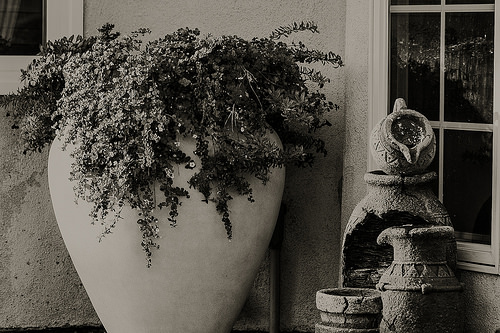

In [ ]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:1]:
    display.display(Image.open(str(image_path)))


In [ ]:

IMG_SIZE=224
FLOWER_DAISY_DIR= os.path.join(data_dir, 'daisy')
FLOWER_SUNFLOWER_DIR= os.path.join(data_dir,'sunflowers')
FLOWER_TULIP_DIR= os.path.join(data_dir,'tulips')
FLOWER_DANDI_DIR= os.path.join(data_dir,'dandelion')
FLOWER_ROSE_DIR= os.path.join(data_dir,'roses')
print(FLOWER_DAISY_DIR)

/root/.keras/datasets/flower_photos/daisy


In [ ]:
def assign_label(img,flower_type):
    return flower_type

In [ ]:
import tqdm
import cv2
def make_train_data(flower_type,DIR):
    print(DIR)
    for img in os.listdir(DIR):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [ ]:
X=[]
Z=[]
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))
print(len(Z))

/root/.keras/datasets/flower_photos/daisy
633
633


In [ ]:
make_train_data('sunflowers',FLOWER_SUNFLOWER_DIR)
print(len(X))

/root/.keras/datasets/flower_photos/sunflowers
1332


In [ ]:
make_train_data('tulip',FLOWER_TULIP_DIR)
print(len(X))

/root/.keras/datasets/flower_photos/tulips
2131


In [ ]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

/root/.keras/datasets/flower_photos/dandelion
3029


In [ ]:
make_train_data('roses',FLOWER_ROSE_DIR)
print(len(X))

/root/.keras/datasets/flower_photos/roses
3670


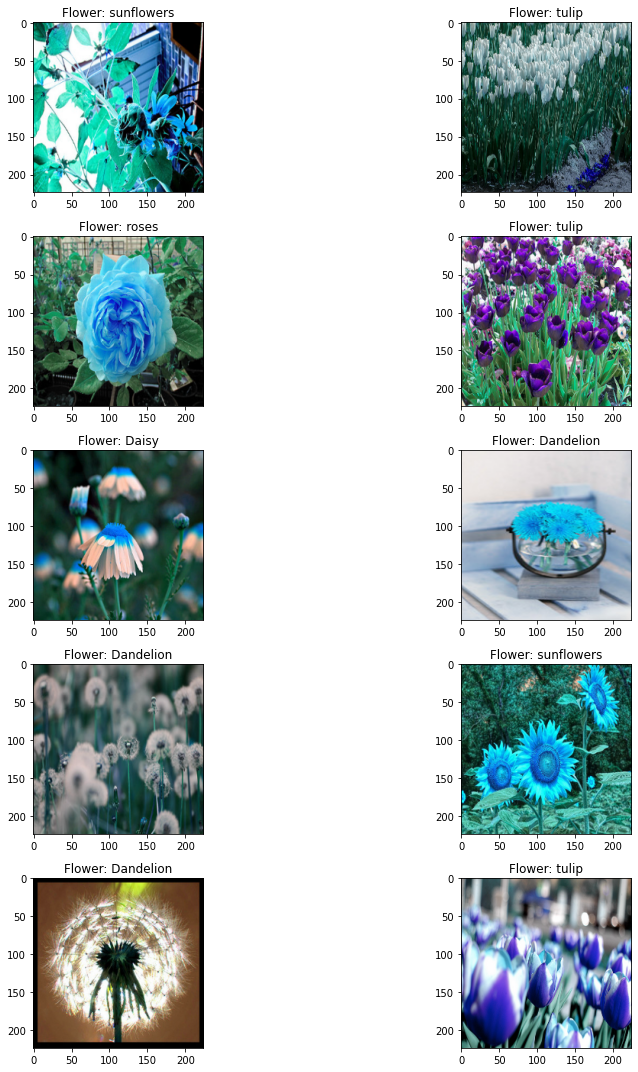

In [ ]:
import random as rn
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [ ]:
#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical




le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [ ]:
np.random.seed(42)
rn.seed(42)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH  = 224
IMG_CHANNELS =3
nclasses  = 5

module_selection = "mobilenet_v2_100_224"
module_handle = "https://tfhub.dev/google/imagenet/{}/feature_vector/4" \
    .format(module_selection)

transfer_model = tf.keras.Sequential([
    hub.KerasLayer(module_handle, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(
        nclasses,
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
transfer_model.build((None,)+(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
History = transfer_model.fit_generator(datagen.flow(x_train,y_train, batch_size=32),
                              epochs = 20, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 32)

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/20
86/86 [==============================] - 150s 2s/step - loss: 1.0106 - accuracy: 0.6119 - val_loss: 0.5840 - val_accuracy: 0.7898
Epoch 2/20
86/86 [==============================] - 148s 2s/step - loss: 0.5865 - accuracy: 0.7834 - val_loss: 0.4562 - val_accuracy: 0.8366
Epoch 3/20
86/86 [==============================] - 149s 2s/step - loss: 0.5059 - accuracy: 0.8161 - val_loss: 0.4023 - val_accuracy: 0.8638
Epoch 4/20
86/86 [==============================] - 149s 2s/step - loss: 0.4351 - accuracy: 0.8525 - val_loss: 0.3815 - val_accuracy: 0.8704
Epoch 5/20
86/86 [==============================] - 149s 2s/step - loss: 0.3973 - accuracy: 0.8594 - val_loss: 0.3715 - val_accuracy: 0.8606
Epoch 6/20
86/86 [==============================] - 150s 2s/step - loss: 0.3744 - accuracy: 0.8692 - val_loss: 0.3575 - val_accuracy: 0.8715
Epoch 7/20
86/86 [==============================] - 150s 2s/step - loss: 0.3648 - accuracy: 0.8699 - val_loss: 0.3451 - val_accuracy: 0.8715
Epoch 8/20
86

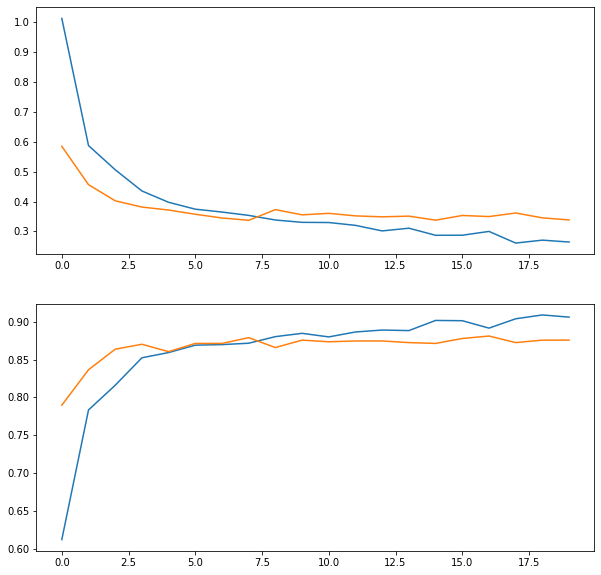

In [ ]:
from matplotlib import pyplot as plt




fig, axs = plt.subplots(2, 1 , figsize=(10,10))
#axs[0, 0].plot(x, y)
##axs[0, 0].set_title('Axis [0, 0]')
#axs[0, 1].plot(x, y, 'tab:orange')
#axs[0, 1].set_title('Axis [0, 1]')
#axs[1, 0].plot(x, -y, 'tab:green')
#axs[1, 0].set_title('Axis [1, 0]')
#axs[1, 1].plot(x, -y, 'tab:red')
#axs[1, 1].set_title('Axis [1, 1]')




axs[0].plot(History.history['loss'])
axs[0].plot(History.history['val_loss'])
axs[1].plot(History.history['accuracy'])
axs[1].plot(History.history['val_accuracy'])


In [ ]:
# getting predictions on val set.
pred=transfer_model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

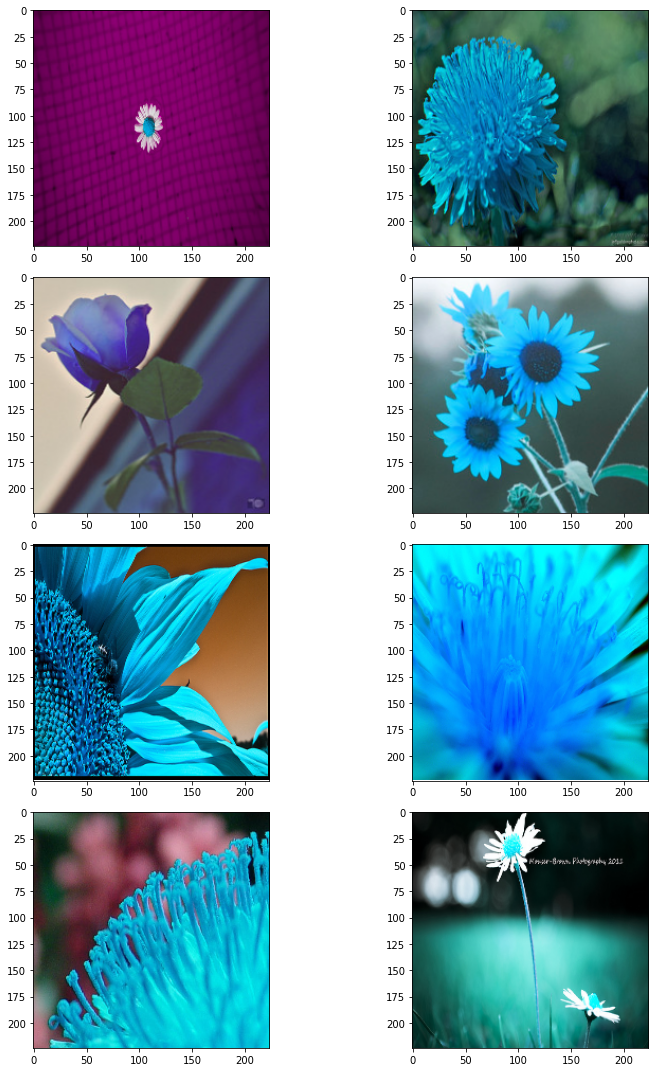

In [ ]:
#warnings.filterwarnings('always')
#warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+
        #                  str(le.inverse_transform([pred_digits[prop_class[count]]]))+
        #                  "\n"+
        #                  "Actual Flower : "+
                      #    str(le.inverse_transform(np.argmax([y_test[prop_class[count]]])
        #                  )))
        plt.tight_layout()
        count+=1